# QA session (24th Jan 2025)

### Question from Yusuke-san

Why reasoning in Bayesian Linear Regression does not match with law of expectations?

### Answer

We made (hidden) assumptions for the data. Specifically,

- $P(w|x, M) = P(w|M)$
- $P(y^*|x^*, w, x, y, M) = P(y^*|x^*, w, M)$

Details can be found in the spread-sheet

### Question from Toshiki 

[...] Marginal likelihood indicates the **expected value of the likelihood of the observed data under the posterior distribution given the current parameters**. [...]. However, since this calculation is essentially an interpolation-based computation, I am skeptical about how much we can trust this value.

[...] In the usual context of machine learning, it is common to prepare training and validation data and perform parameter fitting through cross-validation.
**In Gaussian processes, is it really unnecessary to check the fit to unseen data, not just the marginal likelihood?**


### Answer
Marginal likelihood is defined as 
$$ P(y|x, M) = \int P(y| x, w, M) \color{red}{P(w|M)} \mathrm{d}w $$

It is marginalized with **prior distribution**! Hence there is **no learning here!**

$$ P(y|x, M) = \int P(y| x, w, M) \color{red}{P(w|M)} \mathrm{d}w $$

Marginal likelihood decreases if:
- Prior $P(w|M)$ is zero where $P(y|x, w, M)$ is large (**Too simple**)
- Prior $P(w|M)$ is large where $P(y|x, w, M)$ is small (**Too complex**)


Maxmizing marginal likelihood can adjust your complexity of your model! 
<img src="resources/bayes_model_select.png" width=60%>

(In principle,) we do not need cross-validation. In real-world, we do sometimes...

### Question

What is the benefit of the GPflow?

### Answer

This is the package for GP modeling that Secondmind teams are using. It helps a lot as you see in the Exercises!

In [3]:
# Silence some annyoing warnings:
import os
import warnings

warnings.simplefilter("ignore")
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"

# Support for maths
import numpy as np
import tensorflow as tf

# Plotting tools
from matplotlib import pyplot as plt
# we use the following for plotting figures in jupyter
%matplotlib inline

# GPflow: Gaussian processes library
import gpflow

### Exercise 1
(0) What is the relationship between kernel function $k(x,x')$ and GP $f \sim \mathcal{GP}(0, k)$?

$$Cov(f(x), f(x')) = k(x, x'), \quad Var(f(x)) = k(x, x)$$

Therefore, large kernel value $k(x,x')$ means **$f(x), f(x')$ should take smilar value!** 

(a) What is the effect of the lengthscale parameter on the covariance function?

> It causes the covariances to be higher between more distant locations in the input domain, i.e. nearby samples from the corresponding Gaussian process will be more likely to be similar as the lengthscale increased.

(b) Change the code used above to plot the covariance function showing the effects of the variance on the covariance function. Comment on the effect.

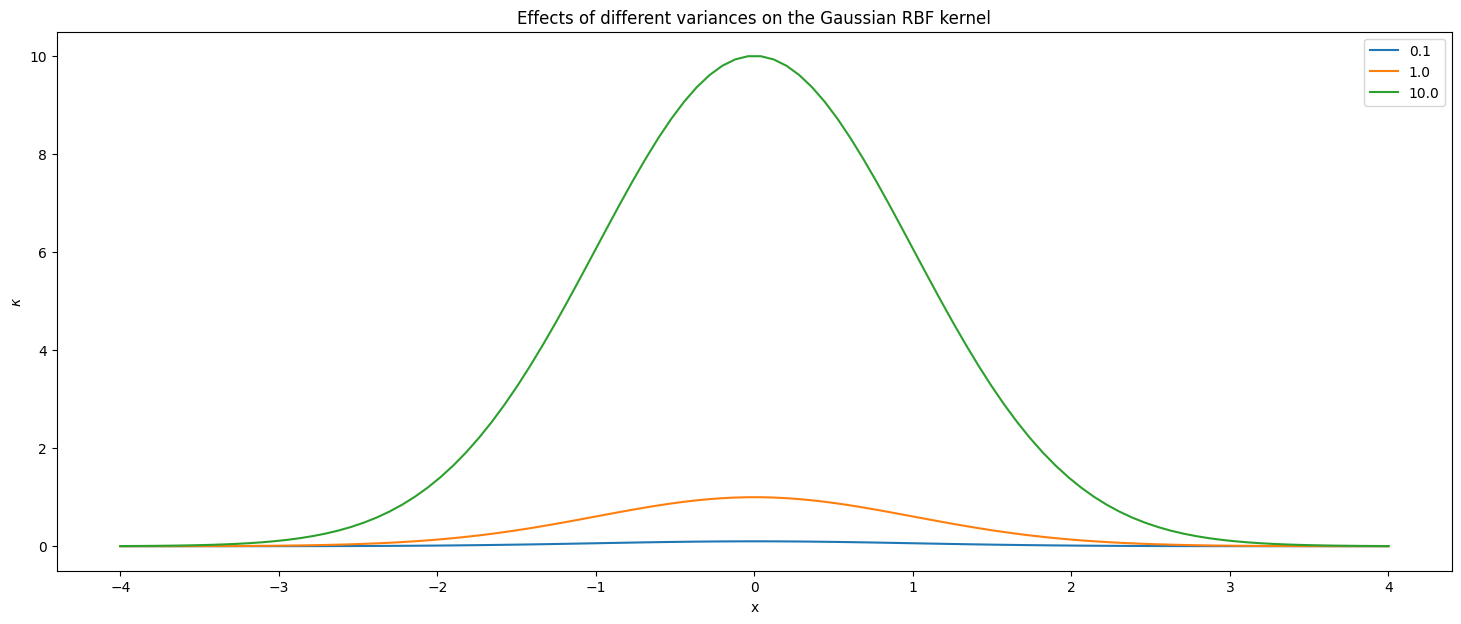

In [7]:
X = np.linspace(-4.,4.,100)[:, None]

k = gpflow.kernels.RBF()

# List of variances
vs = [0.1, 1., 10.]

plt.figure(figsize=(18, 7))

for v in vs:
    # Set the variance parameter of the kernel
    k.variance.assign(v)
    C = k(X, np.array([[0.]]))
    plt.plot(X,C)

# Annotate plot
plt.xlabel("x"), plt.ylabel("$\kappa$") 
plt.title("Effects of different variances on the Gaussian RBF kernel")
plt.legend(labels=vs);

### Question

What is a condition of kernel function ?

### Answer

For any number $n \in \mathbb{N}$ and points $\{x_1, \dots, x_n\}$, kernel matrix $K$ defined as
$$ K = \begin{bmatrix}
k(x_1, x_1) & k(x_1, x_2) &\dots &k(x_1, x_n)\\ 
k(x_2, x_1) & k(x_2, x_2) &\dots &k(x_2, x_n)\\ 
\vdots & \vdots & \ddots & \vdots\\
k(x_n, x_1) & k(x_n, x_2) &\dots &k(x_n, x_n)\\ 
\end{bmatrix} $$
is a valid covariance matrix (a.k.a **positive-semidefinite** matrix)

A matrix $A$ is **Positive-semidefinite** if $v^\top A v \geq 0$ for all vector $v$

**Theorem**:  Given two kernel functions $k_1, k_2$, 
 $$k_+(x, x') = k_1(x, x') + k_2(x, x'), \quad k_\times(x, x') =k_1(x, x') k_2(x, x')$$
 are both kernel function.

---

Proving it would be a good mathematical exercise! ($k_+$ is easy but $k_\times$ is tricky...)

### Exercise 2 and Question
How the shape of GP if we use following kernels
$$k_+(x, x') = k_1(x, x') + k_2(x, x'), \quad k_\times(x, x') =k_1(x, x') k_2(x, x')$$


**Recall:** when kernel $k(x, x')$ is large for some $x, x'$, the values $f(x), f(x')$ should be similar

1. For $f \sim \mathcal{GP}(0, k_+)$, $f(x), f(x')$ are similar if $k_1(x, x')$ **or** $k_2(x, x')$ is large
2. For $f \sim \mathcal{GP}(0, k_\times)$, $f(x), f(x')$ are similar if $k_1(x, x')$ **and** $k_2(x, x')$ is large

*Theorem:* Let $f_1 \sim \mathcal{GP}(0, k_1), f_2 \sim \mathcal{GP}(0, k_2)$ Then, 
1. $f_1 + f_2$ follows $\mathcal{GP}(0, k_1 + k_2)$
2. $f_1  f_2$ follows $\mathcal{GP}(0, k_1 k_2)$


(**Exercise**) Prove it! *Hint: Compute covarinace.*

Distinguish between:
$$f \sim \mathcal{GP}(0, k_{rbf}(x, x') + \cos(2\pi (x -x'))), \quad f \sim \mathcal{GP}(0, k_{rbf}(x, x')\cos(2\pi(x -x'))$$

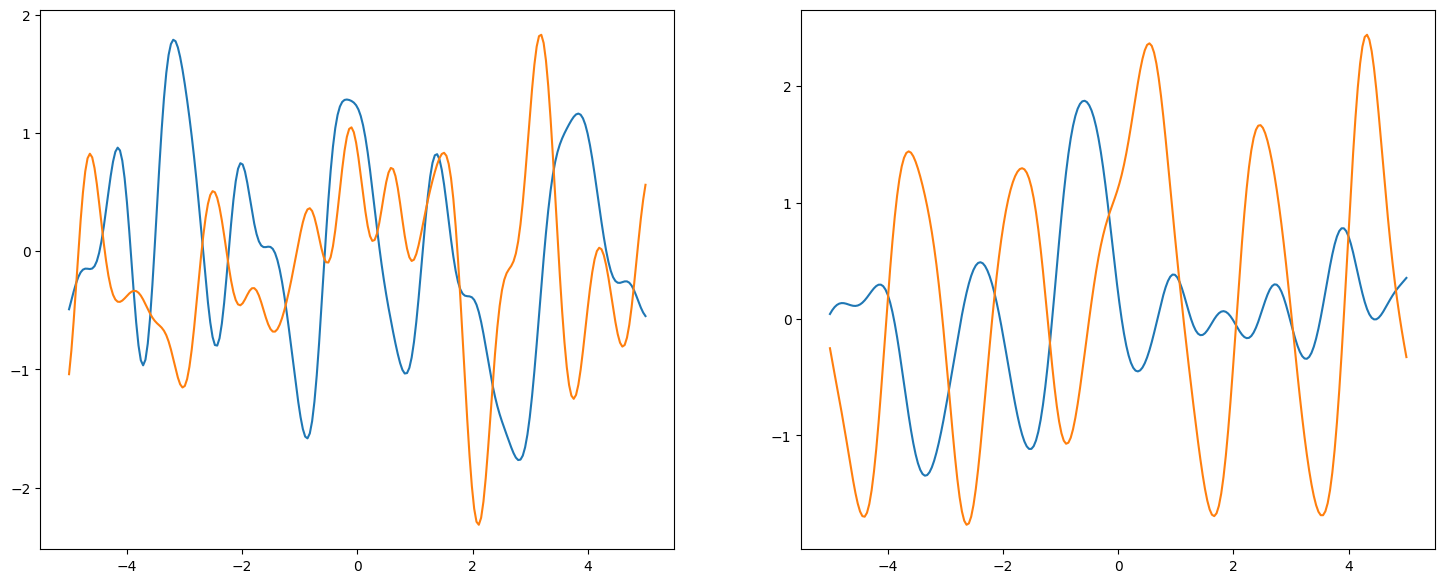

In [62]:

ks = [gpflow.kernels.RBF(lengthscales=.4) * gpflow.kernels.Cosine(lengthscales = 2),
      gpflow.kernels.RBF(lengthscales=.4) + gpflow.kernels.Cosine(lengthscales = 2)]
X = np.linspace(-5., 5., 250)[:, None]


# The mean function is set to 0
mu = np.zeros((250)) # we have 250 sample inputs
# Get the covariance matrix
C  = ks[0](X,X)
    
# Sample 5 times from a multivariate Gaussian distribution with mean 0 and covariance k(X,X)
rng = np.random.default_rng(42)
Z  = rng.multivariate_normal(mu, C, 2)

# Setup figure environment
plt.figure(figsize=(18, 7))

# Show samples on left hand side
plt.subplot(121)
for j in range(2):
    plt.plot(X[:],Z[j,:])
        
C  = ks[1](X,X)
    
# Sample 5 times from a multivariate Gaussian distribution with mean 0 and covariance k(X,X)
Z  = np.random.multivariate_normal(mu, C, 2)

plt.subplot(122)
for j in range(2):
    plt.plot(X[:],Z[j,:])

The left one is product $k_{rbf}(x, x')\cos(2\pi(x -x'))$, the right one is additive $k_{rbf}(x, x') +\cos(2\pi(x -x'))$

### Question

How to select kernels? (e.g. Matern kernel v.s Gaussian Kernel)

### Answer
- Reflect your prior knowledge on function
    - Function is periodic: Use cosine or periodic Mattern kernel
    - Function has linear trend: Use linear kernel
- Combine them adequately
- **Maximize marginal likelihood!**

**Useful facts**
Let $k(x,y) = \phi(x)^\top\phi(y)$. All functions $f$ sampled from $f \sim \mathcal{GP}(0, k)$ can be written as

 $$f(x) = w^\top \phi(x), \quad w \sim \mathcal{N}(0, I)$$

[**Exercise**] Prove it!


**Examples**

- Linear kernel $k(x,y) = x^\top y$: 

$$f(x) = w^\top x, \quad w \sim \mathcal{N}(0, I)$$

- Cosine kernel $k(x,y) = \cos(x - y)$:

 $$f(x) = w_1 \cos(x) + w_2\sin(x), w_1,w_2 \sim \mathcal{N}(0,1)$$


**Useful facts**
Mattern Kernel $\nu$: $$k(x, x') = \frac{1}{\Gamma(\nu) 2^{\nu-1}} \left(\frac{\sqrt{2\nu}}{l} \|x-x'\|\right)^\nu K_\nu \left(\frac{\sqrt{2\nu}}{l} \|x-x'\|\right)$$
- "Mattern 3/2" means Mattern kernel with $\nu = 3/2$
- Exponetial kernel is Mattern kernel with $\nu = 1/2$
- Gaussian kernel is Mattern kernel with $\nu = \infty$
- **Larger $\nu$ means smoother function**

---

### Exercise 3

Can you identify the covariance function used to generate the following samples?

<img src=resources/kernel_samples.png width=80%>

Options: _Periodic * Matern 5/2; Matern 3/2 + Bias; Matern 1/2 * RBF; Linear * Cosine; RBF; Exponential_

<img src=resources/kernel_samples.png width=80%>

(a) RBF (b) Linear * Cosine (c) Matern 3/2 + Bias (d) Exponential (e) Matern 1/2 * RBF (f) Periodic * Matern 5/2

In [46]:
# lambda function, call f(x) to generate data
f = lambda x: -np.cos(2*np.pi*x) + 0.5*np.sin(6*np.pi*x)

# 10 equally spaced sample locations 
X = np.linspace(0.05, 0.95, 10)[:,None]

# y = f(X) + epsilon
Y = f(X) + np.random.normal(0., 0.1, (10,1)) # note that np.random.normal takes mean and s.d. (not variance), 0.1^2 = 0.01


In [57]:
k = gpflow.kernels.RBF(variance=1., lengthscales=0.1)

In [47]:
# New test points to sample function from
Xnew = np.linspace(-0.05, 1.05, 100)[:, None]

# Covariance between training sample points (+ Gaussian noise)
Kxx = (k(X,X) + 1 * np.eye(10))

# Covariance between training and test points
Ksx = k(Xnew, X)

# Covariance between test points
Kss = k(Xnew,Xnew)

# The mean of the GP fit (note that @ is matrix multiplcation: A @ B is equivalent to np.matmul(A,B))
mean = Ksx @ np.linalg.inv(Kxx) @ Y
# The covariance matrix of the GP fit
Cov = Kss - Ksx @ np.linalg.inv(Kxx) @ tf.transpose(Ksx)

In [49]:
def plot_gp(X, m, C, training_points=None):
    """ Plotting utility to plot a GP fit with 95% confidence interval """
    
    m = m.numpy()
    C = C.numpy()
    
    # Plot 95% confidence interval 
    plt.fill_between(X[:,0],
                     m[:,0] - 1.96*np.sqrt(np.diag(C[0,:,:])),
                     m[:,0] + 1.96*np.sqrt(np.diag(C[0,:,:])),
                     alpha=0.5)
    # Plot GP mean and initial training points
    plt.plot(X, m, "-", label="GP fit")
    
    plt.xlabel("x"), plt.ylabel("f")
    
    # Plot training points if included
    if training_points is not None:
        X_, Y_ = training_points
        plt.plot(X_, Y_, "kx", mew=2, label="sample points")
        
    plt.legend()

### Exercise 4

The initial fit would be:

In [58]:
k = gpflow.kernels.RBF(variance=1., lengthscales=0.1)
m = gpflow.models.GPR((X, Y), kernel=k)

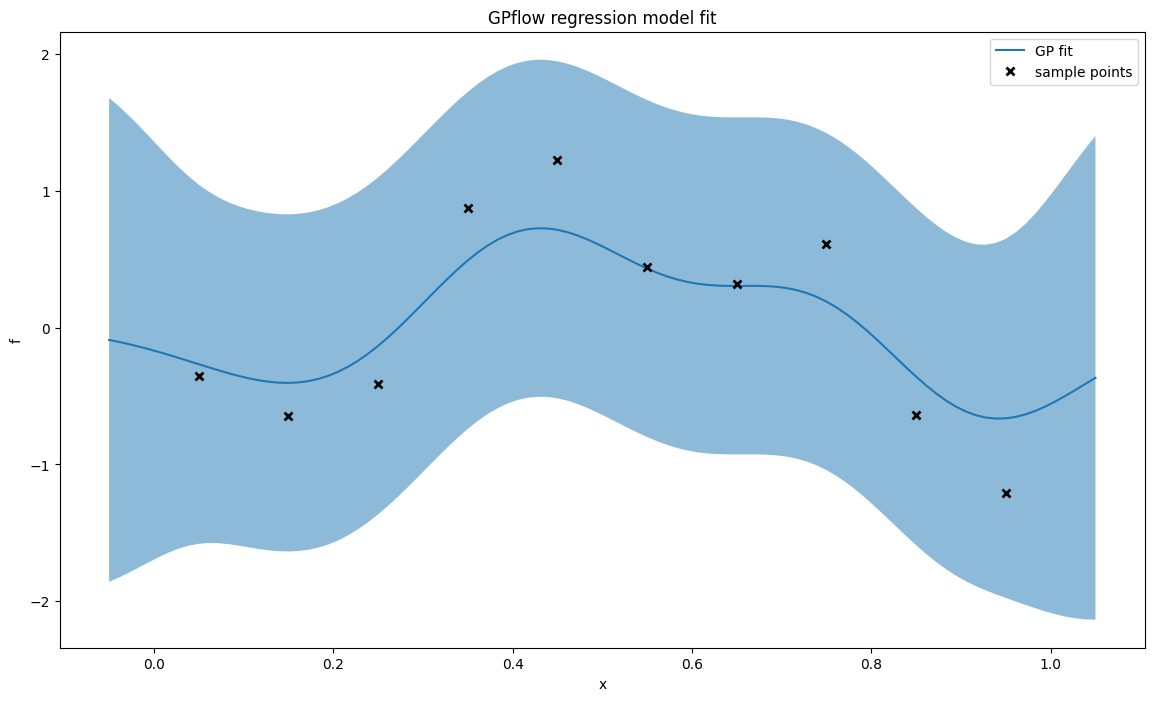

In [59]:
# Use GPflow model to calculate the mean and covariance of the fit at Xnew
mean, Cov = m.predict_f(Xnew, full_cov=True)

plt.figure(figsize=(14, 8))

# Plot the GP fit mean and covariance
plot_gp(Xnew, mean, Cov, training_points=(X,Y))
plt.title("GPflow regression model fit");

(a) What do you think of this initial fit? Does the prior given by the GP seem to be adapted?

It's clear that the observations are captured in the confidence interval, but the fit is not particularly good. The parameters used may not be the best they can be to minimise the loss of the fit.


(b) The parameters of the model can be edited much like those of the kernel.
Change the values of the parameters to try and obtain a better fit of the GP. You can recalculate the updated mean and covariance after changing the values by calling `m.predict_noiseless` as above.

name,class,transform,prior,trainable,shape,dtype,value
GPR.kernel.variance,Parameter,Softplus,,True,(),float64,1
GPR.kernel.lengthscales,Parameter,Softplus,,True,(),float64,0.1
GPR.likelihood.variance,Parameter,Softplus + Shift,,True,(),float64,0.01


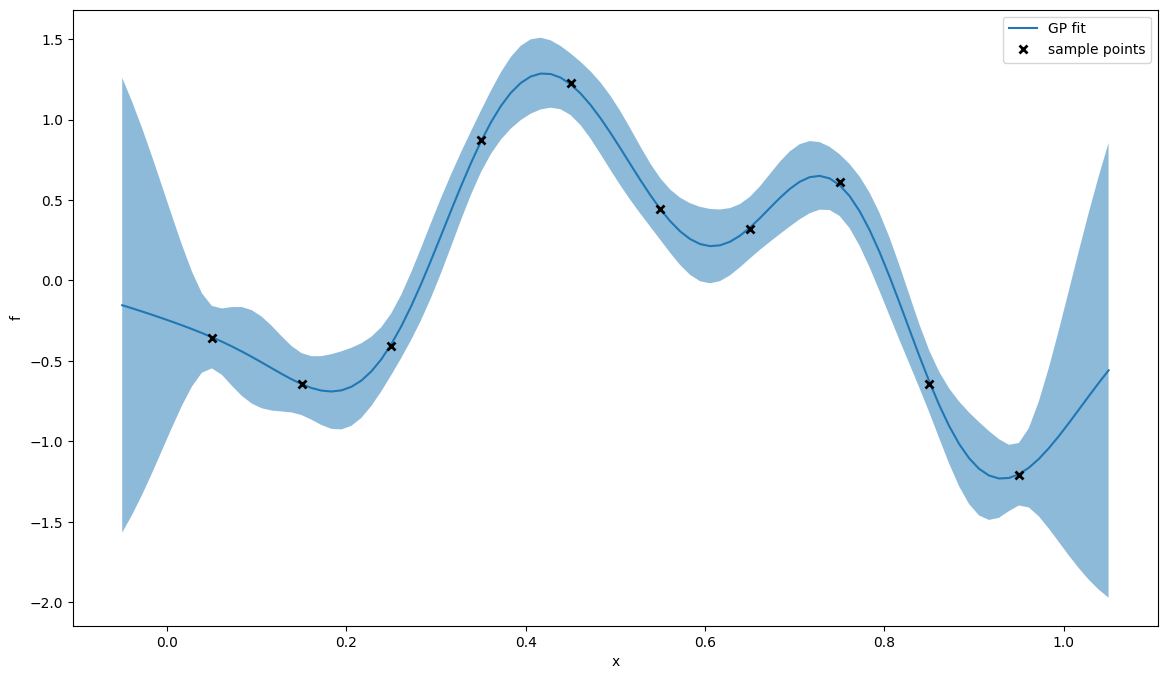

In [60]:
m.kernel.variance.assign(1.0)
m.kernel.lengthscales.assign(0.1)
m.likelihood.variance.assign(0.01)

mean, Cov = m.predict_f(Xnew, full_cov=True)

plt.figure(figsize=(14, 8))
# Plot the GP fit mean and covariance
plot_gp(Xnew, mean, Cov, training_points=(X,Y))

# Preview the regression model
m

(c) Given that we can obtain the mean and covariance of the GP fit, we can also sample the GP posterior as a multivariate Gaussian process. This can be done as in Section 4, where we sampled the priors as defined by the kernels, i.e. with `np.random.multivariate_normal`. Obtain 10 samples from the GP posterior and plot them alongside the data. Try to simulate noisy measurements using `m.predict_y` (rather than `m.predict_f`).

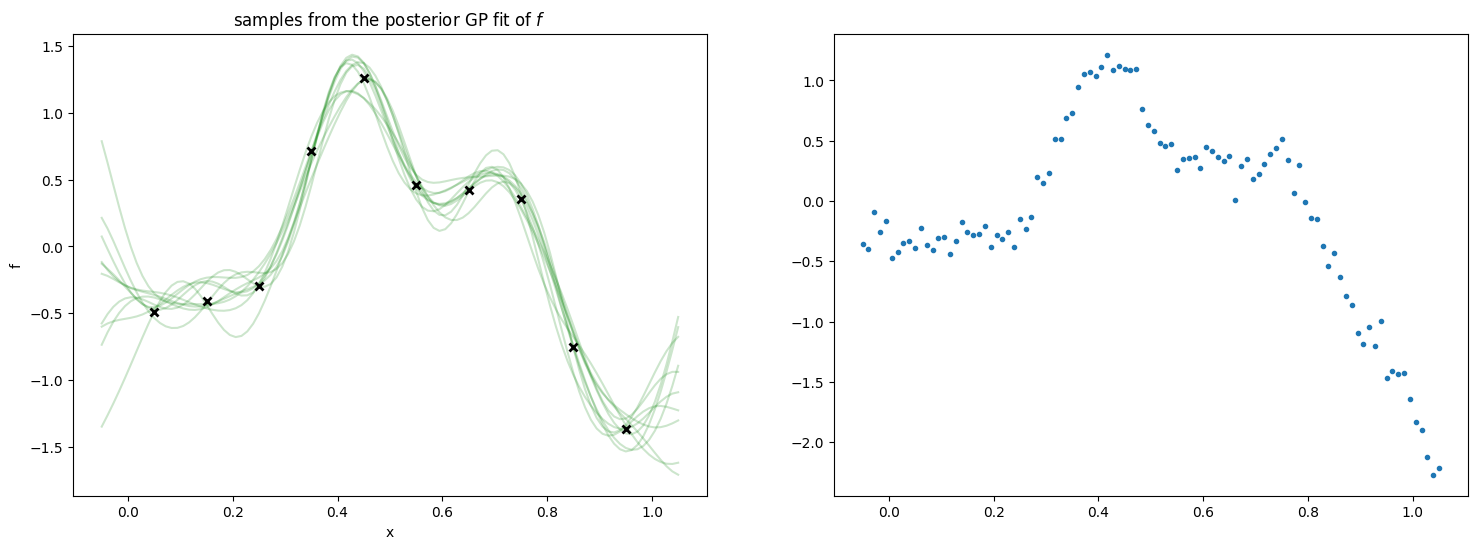

In [18]:
plt.figure(figsize=(18, 6))

mean, Cov = m.predict_f(Xnew, full_cov=True)

Z  = np.random.multivariate_normal(mean[:,0], Cov[0,:,:], 10)
plt.subplot(121)
for z in Z:
    plt.plot(Xnew, z, "g-", alpha=0.2)
plt.plot(X, Y, "kx", mew=2)
plt.xlabel("x"), plt.ylabel("f"), plt.title("samples from the posterior GP fit of $f$")    

Cov = gpflow.utilities.add_noise_cov(Cov, m.likelihood.variance)
z  = np.random.multivariate_normal(mean[:,0], Cov[0,:,:])
plt.subplot(122)
plt.plot(Xnew, z, ".")

### Question

Do you manually tune them in reality?

### Answer

No! GPflow provides tools to tune them by maximizing marginal likelihood

```python
o = gpflow.optimizers.Scipy()
o.minimize(m.training_loss, m.trainable_variables)
```

### Question

What is the difference between likelihood variance and kernel variance?

### Answer
kernel variance is the scalar $\sigma$ applied to RBF kernel:
$$k_{\mathrm{rbf}} = {\color{red}{\sigma}} \exp\left(\|x-x'\|^2 / l\right)$$
which represents the **scale of the function**


likelihood variance is $\lambda$ that appears marginal likelihood of GP
$$ \log p(y|x, \mathcal{GP}(0, k)) = \mathbf{y}^\top (K + {\color{red}{\lambda}} I)^{-1} \mathbf{y} - \frac12 \log \det(K + {\color{red}{\lambda}}I) - \frac{n}2 \log 2 \pi$$ 
which represents **the noise in data**

[**Exercise**] Derive marginal likelihood of GP

In [19]:
o = gpflow.optimizers.Scipy()
o.minimize(m.training_loss, m.trainable_variables)

name,class,transform,prior,trainable,shape,dtype,value
GPR.kernel.variance,Parameter,Softplus,,True,(),float64,0.660752
GPR.kernel.lengthscales,Parameter,Softplus,,True,(),float64,0.122209
GPR.likelihood.variance,Parameter,Softplus + Shift,,True,(),float64,1.00309e-06


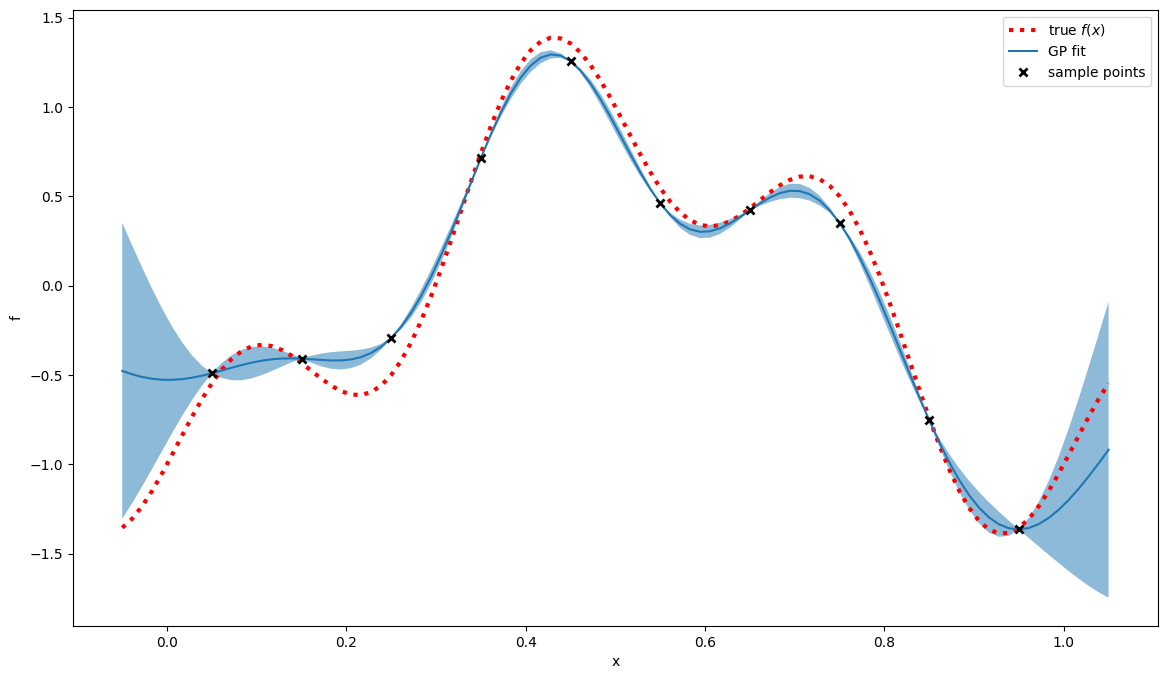

In [20]:
# Get mean and covariance of optimised GP
mean, Cov = m.predict_f(Xnew, full_cov=True)

# Setup the figure environment
plt.figure(figsize=(14, 8))

# Plot the GP fit mean and covariance
plt.plot(Xnew, f(Xnew), "r:", lw=3, label="true $f(x)$")
plot_gp(Xnew, mean, Cov, training_points=(X,Y))

In [21]:
# Fix the Gaussian noise variance at 0.01 
m.likelihood.variance.assign(0.01) # (Reset the parameter first)
gpflow.set_trainable(m.likelihood.variance, False)

# Reoptimise
o = gpflow.optimizers.Scipy()
o.minimize(m.training_loss, m.trainable_variables)
m

name,class,transform,prior,trainable,shape,dtype,value
GPR.kernel.variance,Parameter,Softplus,,True,(),float64,0.62179
GPR.kernel.lengthscales,Parameter,Softplus,,True,(),float64,0.1199
GPR.likelihood.variance,Parameter,Softplus + Shift,,False,(),float64,0.01


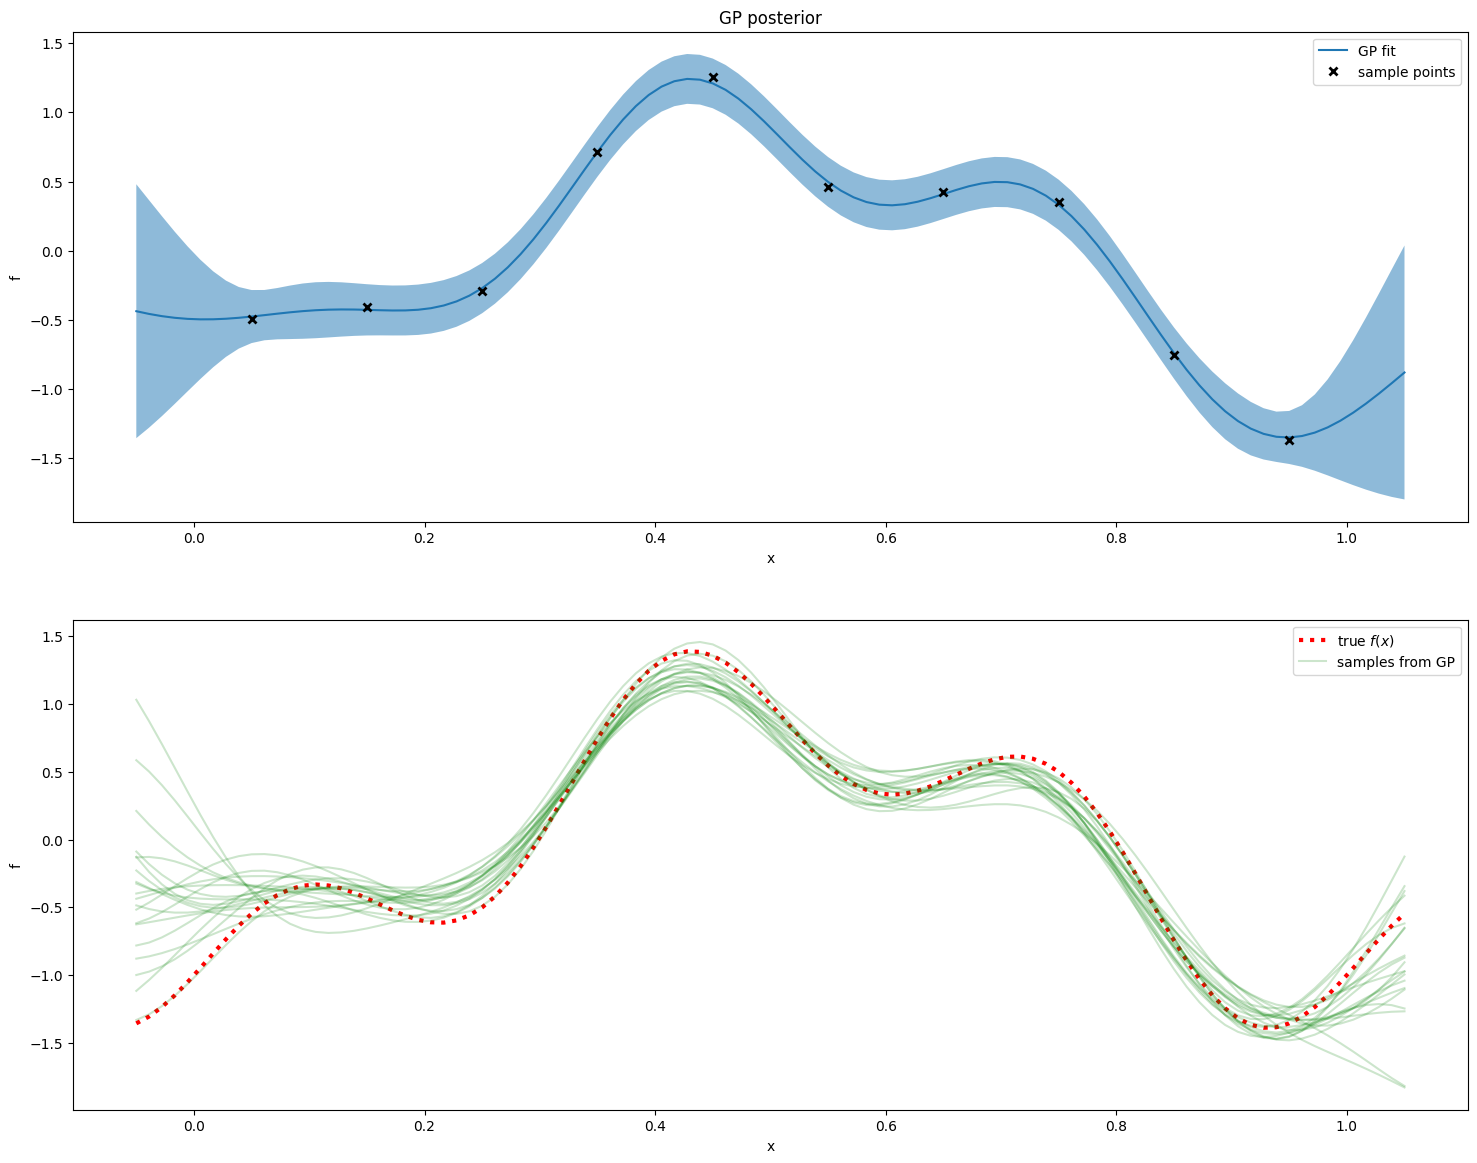

In [22]:
# Get mean and covariance of optimised GP
mean, Cov = m.predict_f(Xnew, full_cov=True)

# Setup our figure environment
plt.figure(figsize=(18, 14))

# The top plot shows our mean regression fit and 95% confidence intervals 
plt.subplot(211)
# Plot the GP fit mean and covariance
plot_gp(Xnew, mean, Cov, training_points=(X,Y))
plt.title("GP posterior")
plt.subplot(212)

plt.plot(Xnew, f(Xnew),"r:", lw=3)

Z  = np.random.multivariate_normal(mean[:,0], Cov[0,:,:], 20)
for z in Z:
    plt.plot(Xnew,z, "g-", alpha=0.2)
    
plt.xlabel("x"), plt.ylabel("f")
plt.legend(labels=["true $f(x)$", "samples from GP"]);

### Exercise 5 [Optional]

(a) Try predicting the outside of the data 

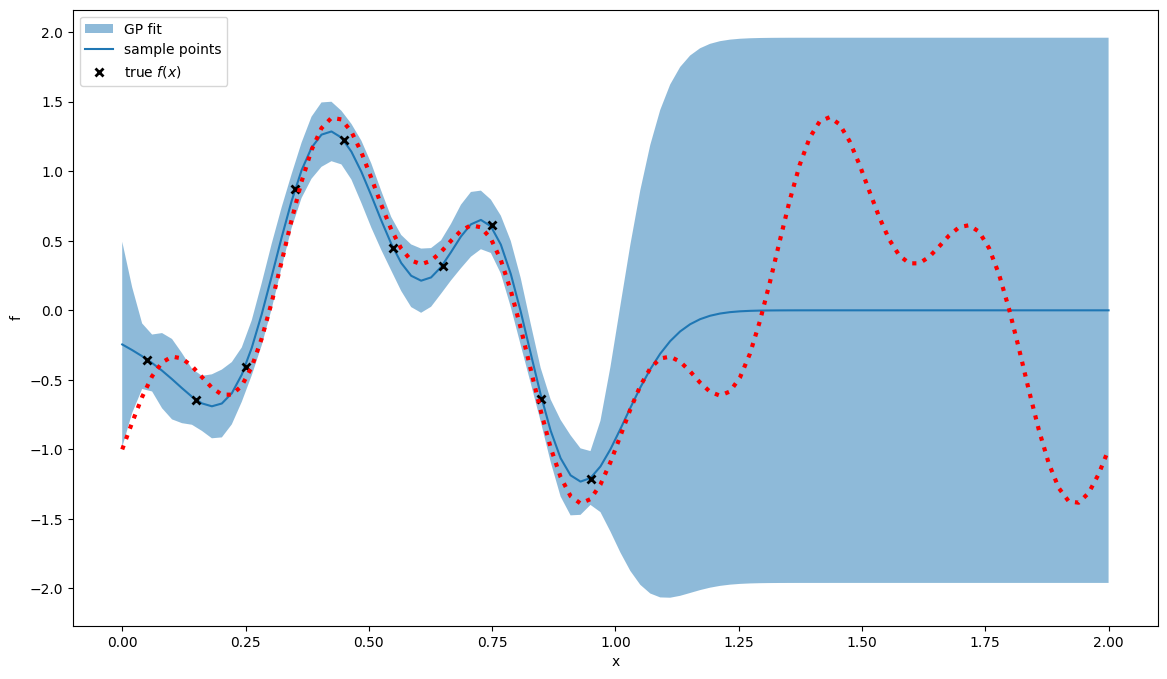

In [61]:
Xnew = np.linspace(0., 2., 100)[:, None]
mean, Cov = m.predict_f(Xnew, full_cov=True)

plt.figure(figsize=(14, 8))
plot_gp(Xnew, mean, Cov, training_points=(X,Y))
plt.plot(Xnew, f(Xnew), "r:", lw=3)
plt.legend(labels=["GP fit", "sample points", "true $f(x)$"]);

(b) Comment on the fit of the GP, and the uncertainty in regions where we have no observations. Is the GP still a good fit? How might we produce a better fit, for example, if we knew $f(x)$ had a periodic nature?

The prediction becomes useless in the areas where we are extrapolating, which makes some degree of sense. However, since the function is sinusoidal, we can see there is some periodicity that we may be able to exploit in our GP fit


In [25]:
import pickle

# Load in the data
with open("resources/mauna_loa", "rb") as fid:
    data = pickle.load(fid)
    
print("\nData keys:")
print(data.keys())

print("\nCitation:")
print(data['citation'])

print("\nInfo:")
print(data['info'])


Data keys:
dict_keys(['X', 'Y', 'Xtest', 'Ytest', 'info', 'citation', 'details', 'files', 'license', 'size', 'urls'])

Citation:
Mauna Loa Data. Dr. Pieter Tans, NOAA/ESRL (www.esrl.noaa.gov/gmd/ccgg/trends/) and Dr. Ralph Keeling, Scripps Institution of Oceanography (scrippsco2.ucsd.edu/).

Info:
Mauna Loa data with 545 values used as training points.


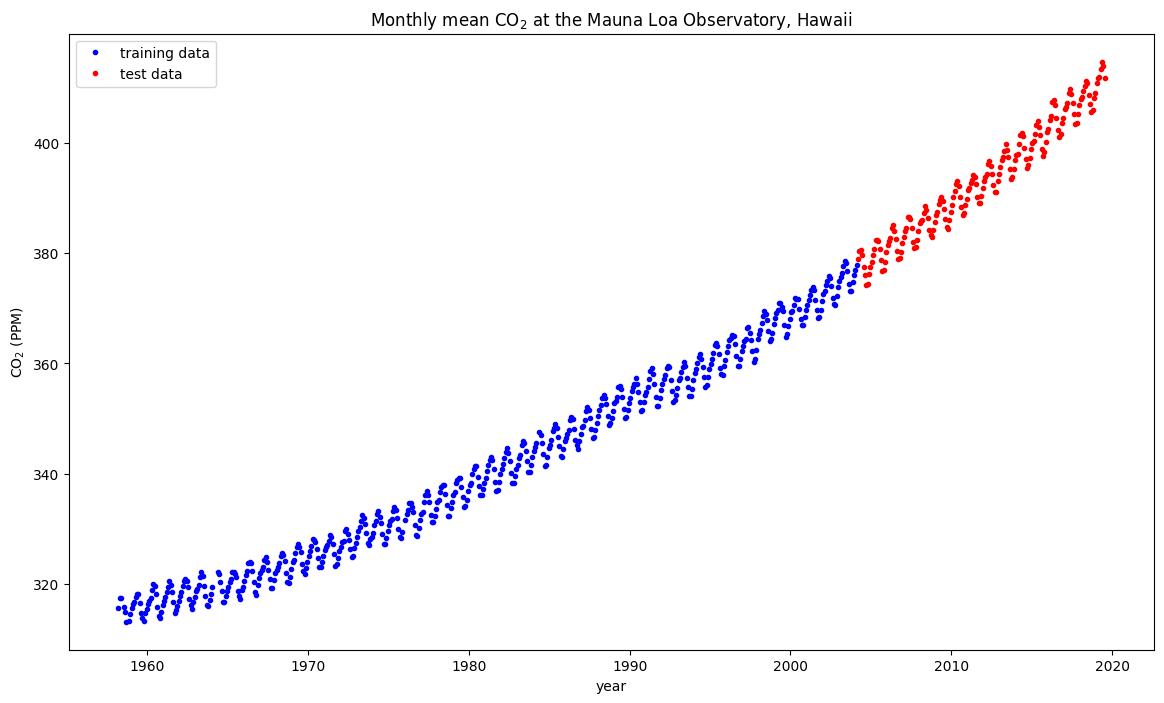

In [26]:
# Training data (X = input, Y = observation)
X, Y = data['X'], data['Y']

# Test data (Xtest = input, Ytest = observations)
Xtest, Ytest = data['Xtest'], data['Ytest']

# Set up our plotting environment
plt.figure(figsize=(14, 8))

# Plot the training data in blue and the test data in red
plt.plot(X, Y, "b.", Xtest, Ytest, "r.")

# Annotate plot
plt.legend(labels=["training data", "test data"])
plt.xlabel("year"), plt.ylabel("CO$_2$ (PPM)"), plt.title("Monthly mean CO$_2$ at the Mauna Loa Observatory, Hawaii");

In [27]:
X = X[::2, :]
Y = Y[::2, :]

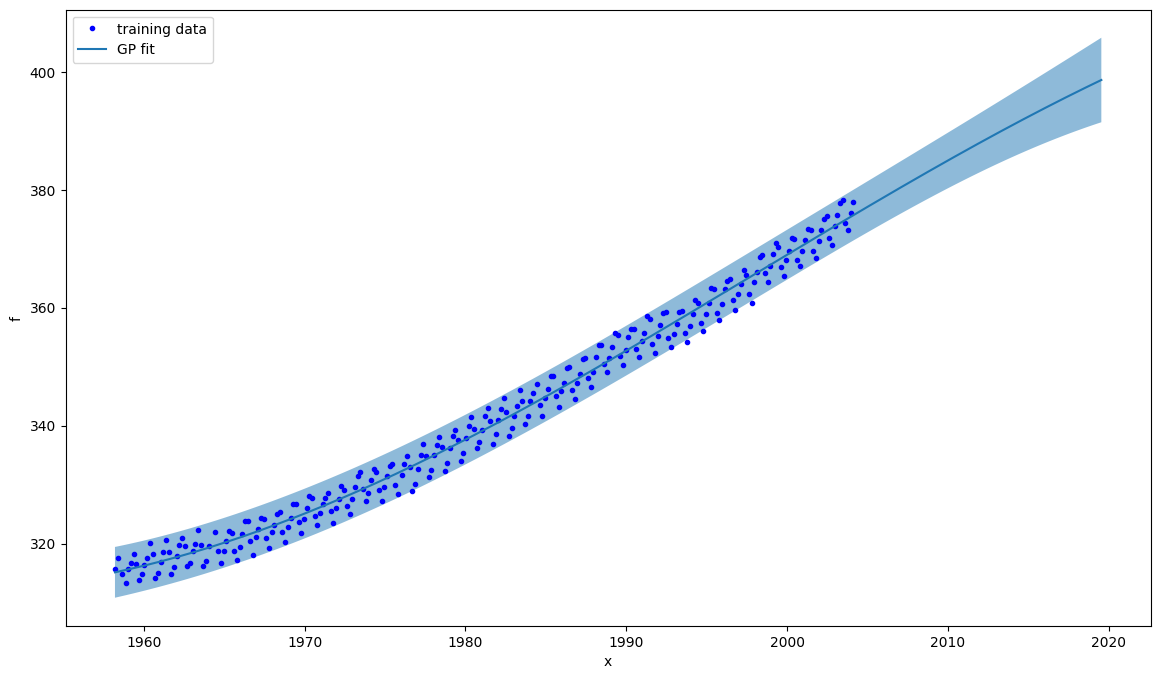

In [29]:
Xnew = np.vstack([X, Xtest])

# Currently GPflow doesn't support m.predict_y(..., full_cov=True), so we write our own:
def predict_y(model, X):
    mean, Cov = model.predict_f(X, full_cov=True)
    Cov = gpflow.utilities.add_noise_cov(Cov, model.likelihood.variance)
    return mean, Cov

mean, Cov = predict_y(m, Xnew)

plt.figure(figsize=(14, 8))
plt.plot(X, Y, "b.", label="training data")
plot_gp(Xnew, mean, Cov)


In [30]:
# Effectively remove noise parameter (needs to be >0, so select value that is very low)
m.likelihood.variance.assign(0.00001)
gpflow.set_trainable(m.likelihood.variance, False)

# We will fix the variance as well, so that only the lengthscale is optimised
m.kernel.variance.assign(10.)
gpflow.set_trainable(m.kernel.variance, False)

# This should minimize the lengthscale to fit closely to the training points
o = gpflow.optimizers.Scipy()
o.minimize(m.training_loss, m.trainable_variables)
m

name,class,transform,prior,trainable,shape,dtype,value
GPR.kernel.variance,Parameter,Softplus,,False,(),float64,10
GPR.kernel.lengthscales,Parameter,Softplus,,True,(),float64,9.71846e-105
GPR.likelihood.variance,Parameter,Softplus + Shift,,False,(),float64,1e-05


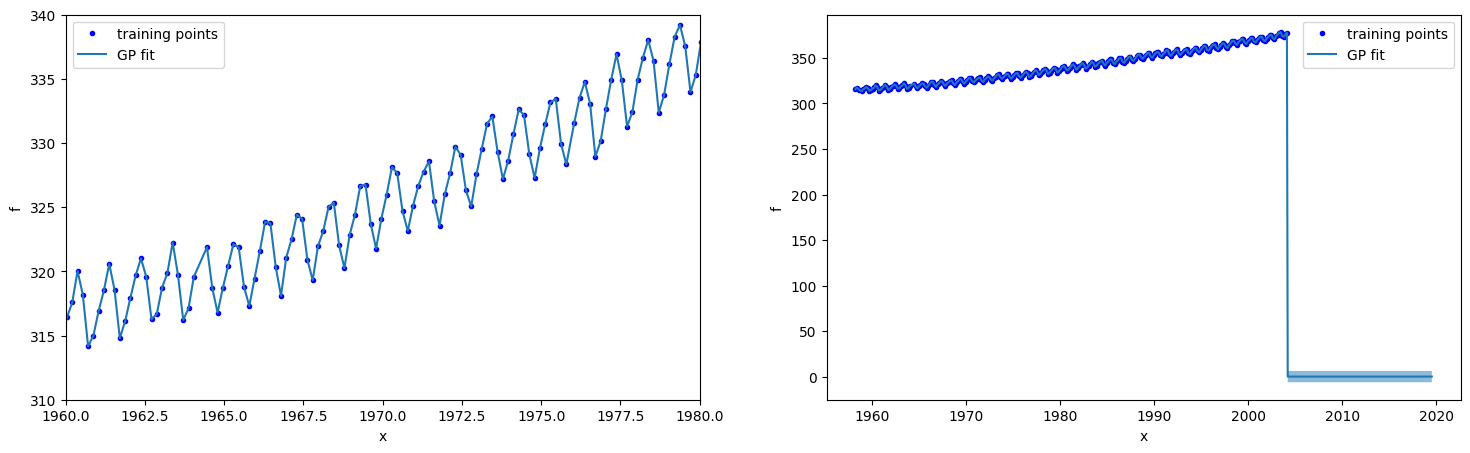

In [31]:
mean, Cov = predict_y(m, Xnew)

plt.figure(figsize=(18, 5))

# The left plot shows the GP fit to a subsample of our training set
plt.subplot(121)
plt.plot(X, Y, "b.", label="training points")
plot_gp(Xnew, mean, Cov)
plt.gca().set_xlim([1960,1980]), plt.gca().set_ylim([310, 340])

# The right plot shows that the GP has no predictive power and reverts to 0
plt.subplot(122)
plt.plot(X, Y, "b.", label="training points")
plot_gp(Xnew, mean, Cov)


### Exercise 6 [Optional]

(a) Create a `Linear` kernel with reasonable estimates of the parameters that represent the trend?

```python
k_L = gpflow.kernels.Linear(variance=1.)
```

(b) How might we encode this trend in the mean estimate of the GP ?

Use a mapping function to represent the linear trend. We can hard code the parameters (gradient and intercept), or give them priors.

(c) Create a GP regression model using the kernels to fit the data. Comment on good is the fit and the predictive power of the model? 

```python
# Linear covariance function
m1 = gpflow.models.GPR(
    (X, Y), 
    kernel=gpflow.kernels.Linear(variance=1.) + gpflow.kernels.Bias(360),
)

mean, Cov = predict_y(m1, Xnew)

plt.figure(figsize=(14,8))
plot_gp(Xnew, mean, Cov)
plt.plot(X, Y, ".b", Xtest, Ytest, ".r", alpha=0.4);
plt.legend(labels=["GP fit","training points", "test points"])
```

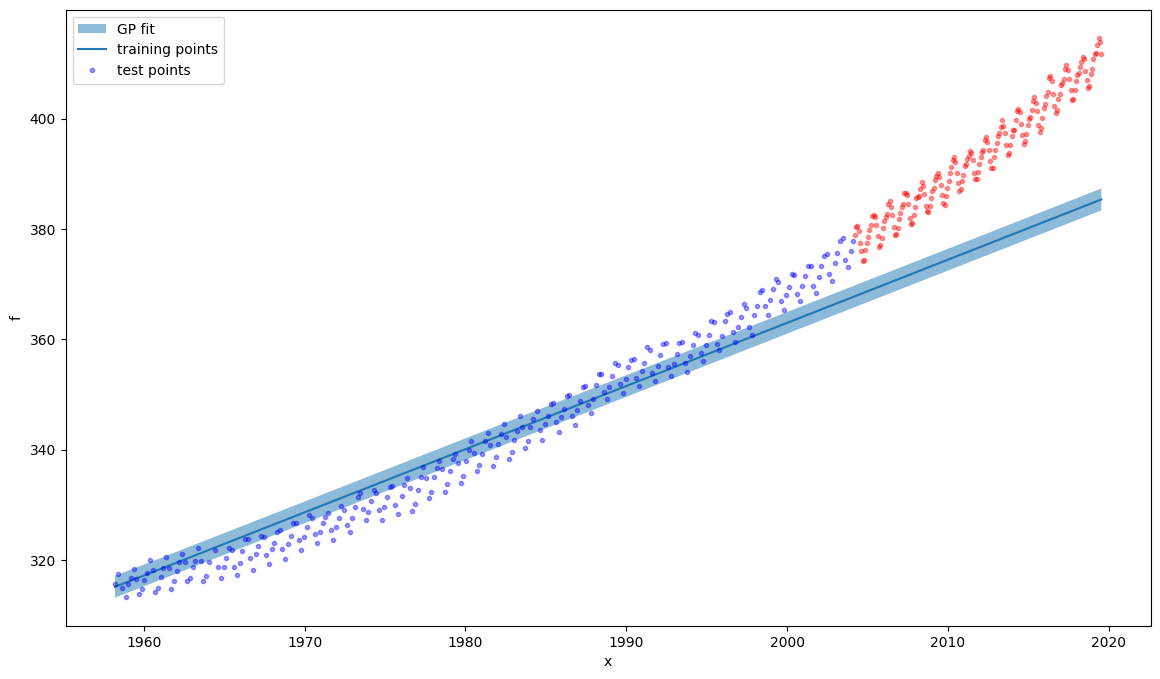

In [33]:
# Linear covariance function
m1 = gpflow.models.GPR(
    (X, Y), 
    kernel=gpflow.kernels.Linear(variance=1.) + gpflow.kernels.Bias(360),
)

mean, Cov = predict_y(m1, Xnew)

plt.figure(figsize=(14,8))
plot_gp(Xnew, mean, Cov)
plt.plot(X, Y, ".b", Xtest, Ytest, ".r", alpha=0.4);
plt.legend(labels=["GP fit","training points", "test points"]);



### Exercise 7

What improvements might be made to the GP model, for example in terms combinations of kernels and parameters, to get a better fit, especially for the prediction of our testing data?

- the number of optimisation restarts of the hyperparameters. 
- add mean function of GP
- try different combination of kernels, reduce redundant kernel